
<h1>Le problème du voyageur de commerce</h1>

Ce problème est apparu quand des commerçants ont voulu vendre des produits dans différentes villes et qu'il fallait trouver le meilleur chemin pour passer par toutes les villes sans repasser par une ville déjà visitée. De manière générale, l'humain résoud ce problème aisément pour un petit nombre de points. Cependant, quand on travaille dans le commerce ou en logistique le nombre de points tends à augmenter très rapidement ce qui complique la tâche.

L'exemple que nous allons utiliser est le TSP mais avec les 25 (ou 100 si possible) plus grandes villes du monde.
Les pistes à tester :
- Utiliser un algorithme génétique pour trouver la meilleure solution
- Utiliser un algorithme de recuit simulé pour trouver la meilleure solution
- Utiliser un grid search
- Utiliser un algorithme de descente de gradient
- Utiliser le hasard pour trouver la meilleure solution
- Utiliser une optimisation bayésienne
- Calculez toutes les permutations possibles
- Proposez ce que vous voulez

Le document PDF dans le dossier vous donnera toutes les informations nécessaires pour votre rapport.


# **Méthode: Recuit simulé**

## Initialisation

Afin de proposer une solution au problème du TSP, nous allons étudier l'algorithme du recuit simulé qui est méthode métaheuristique dans laquelle on accepte des solutions moins optimales afin de se rapprocher de la solution optimale.


  Applicable à de nombreux problèmes, nous allons le détailler en plusieurs étapes:
  1. Obtention d'une solution idéale
  2. Visualisation du chemin parcouru
  3. Estimation de la performance de l'algotithme
  4. Interprétation des résultats

Dans cet exercice, nous avons à notre disposition un jeu de données de 1000 villes en format csv, c'est à dire "Comma Separated Values". Cependant, afin de vérifier qu'un algorithme fonctionne, mieux vaut le tester d'abord sur un échantillon de données plus restreint.


La première étape est d'importer les fonctions qui vont nous être utiles dans l'algorithme:
- pandas: permet de manipuler des dataframes
- random: permet de générer des nombres aléatoires
- math: permet d'utiliser toutes notations mathématiques
- matplotlib.pyplot: permet de visualiser des données par diverses représentations graphiques
- great_circle: fonction de geopy, permet de calculer une distance ellipsoidale entre deux villes contenant une paire de coordonnées
- folium: permet de visualiser des données sur un planisphère interactif
- time: permet de réaliser une estimation du temps d'éxécution

In [26]:
# 1: Importation des fonctions
import pandas as pd
import random
import math
import matplotlib.pyplot as plt
from geopy.distance import great_circle
import folium
import time

Ainsi, on utilise la fonction read_csv() afin de lire notre jeu de données dans le notebook en prenant soin de définir le séparateur comme étant un point virgule étant donné qu'il s'agit d'un fichier csv. De plus, afin d'importer le fichier, nous pouvons écrire le chemin dans lequel se trouve le fichier ou bien comme ici, utiliser un lien de téléchargement direct vers Seafile

In [27]:
#2: Chargement des données
data_villes = pd.read_csv("https://seafile.unistra.fr/f/2f58728945144d668d6c/?dl=1", sep=";", encoding="latin-1") # Lecture du dataset

L'échantillon que l'on va choisir sera les 100 villes les plus peuplées. Ainsi, on classe les villes avec la fonction sort() dans l'ordre décroissant en mettant le paramètre ascending=False et en spécifiant bien qu'il s'agit de la variable "Population.
La fonction head(n=) permet d'afficher le nombre souhaité de valeur

In [28]:
#3: Ordonner le dataset
data_villes = data_villes.sort_values(by="Population", ascending=False).head(100)  # Prendre les 100 premières villes les plus peulées

Pour des soucis par la suite de format, nous allons transformer toutes nos coordonnées en tuples:

In [29]:
#4: Extraction des coordonnées et conversion en une liste de tuples
coords_list = [tuple(map(float, coord.split(','))) for coord in data_villes['Coordinates']]

Etant donné qu'il nous faut un point de départ, nous avons décidé de prendre "Shanghai" comme ville départ. Cependant, il faut vérifier rapidement que cette ville se trouve bien dans le dataset. Pour cela on utilise tout simplement des conditions en usant des fonctions pandas propres aux datasets comme le .values

In [30]:
#5: Vérification de la présence de la ville départ
if 'Shanghai' in data_villes['Name'].values: #Cherche dans la colonne "Names", le nom "Shanghai"
    print("'Shanghai' est dans le dataset!")
else:
    print("'Shanghai' n'est pas dans le top 100 dans le dataset.")
    shanghai_idx = 0

'Shanghai' est dans le dataset!


Maintenant que nous avons bien confirmé sa présence, nous pouvons la mettre en index de la configuration initiale en utilisant la fonction .index :

In [31]:
#6: Indexation de la configuration initiale:
Noms = list(data_villes['Name'])
shanghai_idx = Noms.index('Shanghai')

## Paramètres d'entrée

Nous allons définir deux fonctions principales qui vont calculer les distances entre deux villes et le coût que cela engendre de changer de configuration:
- La fonction distance qui utilise la fonction great_cycle() avec comme paramètres d'entrée, les deux villes choisies et en spécifiant que l'on souhaite l'avoir en km.
- La fonction calculate_cost() qui prend la solution non optimale actuelle et initialise la meilleure solution et son coût à la solution courante

In [32]:
#7: Définition des fonctions de base

# Fonction pour calculer la distance entre deux villes
def distance(ville1, ville2):
    return great_circle(ville1, ville2).km

# Fonction pour calculer le coût d'un trajet
def calculate_cost(solution, coords_list):
    return sum(distance(coords_list[solution[i]], coords_list[solution[(i+1)%len(solution)]]) for i in range(len(solution)))

## Algorithme

L'algorithme se base sur une température fictive qui est élevée de base et fonction du nombre de villes choisies.

L'algorithme prend donc en paramètre d'entrée:
- les distances calculées precedemment grâce à la fonction coords
- la température initiale t0
- le facteur de refroidissement que l'on choisit ici près de 1 pour un refroidissment lent, augmentant le nombre d'itérations
- l'index de la configuration initiale

In [33]:

#8: Fonction d'optimisation par recuit simulé
def simulated_annealing_tsp_v2(coords, initial_temperature, cooling_rate, shanghai_idx): #Définition des inputs
    n = len(coords) #Estimation de la longueur de la liste contenant les distances

    current_solution = list(range(n)) #Initialisation de la solution courante de toutes les villes
    current_solution.remove(shanghai_idx) #sauf "Shanghai"
    random.shuffle(current_solution) #Mélange de la liste contenant toutes les villes sauf Shanghai  aléatoirement
    current_solution = [shanghai_idx] + current_solution #Ajout de Shanghai en première position (fixe)

    current_cost = calculate_cost(current_solution, coords_list) #Calcul du coût initial
    best_cost = current_cost #Definition du coût initial comme étant le meilleur cout
    best_solution = current_solution #Definition de la solution initiale comme étant lea meilleure solution (on accepte au départ des solutions non optimales)

#Paramètrage de la témpérature

    temperature = initial_temperature #Définition de la température initiale comme étant la température actuelle
    best_distances = [] #Création d'une liste qui contiendra la meilleure distance

#Conditions

    while temperature > 1e-10:  #l'algorithme continue tant que la température est supérieure à une certaine valeur (très petite car solution idéale atteinte quant T tend vers 0 = système figé)
        new_solution = list(current_solution)
        i, j = random.sample(range(1, n), 2)  # ne pas échanger Shanghai
        new_solution[i], new_solution[j] = new_solution[j], new_solution[i] #Génération nouvelle solution
        new_cost = calculate_cost(new_solution, coords_list) #Calcul du nouveau coût
        cost_diff = new_cost - current_cost #Calcul de la différence d'énergie due à la modification de la configuration

 #Règle de métropolis:

        if cost_diff < 0 or math.exp(-cost_diff / temperature) > random.random(): #Si la nouvelle solution a un coût inférieur ou acceptée avec une certaine probabilité alors elle remplace la solution courante
            current_solution = new_solution
            current_cost = new_cost

            if new_cost < best_cost: #Si elle a également un coût inférieur à la meilleure solution, alors la meillure solution trouvée devient la meilleure solution
                best_cost = new_cost
                best_solution = new_solution

        best_distances.append(best_cost) #Ajout du meilleur coût avec la meilleure distance
        temperature *= cooling_rate # Mise à jour de la température (processus de recuit)

    return best_solution, best_cost, best_distances #Les outputs sont la meilleure solution, meilleur coût, meilleure distance

# Exécution du recuit simulé
best_route, best_distance, best_distances = simulated_annealing_tsp_v2(coords_list, 10000, 0.995, shanghai_idx)

print("Meilleure route:", best_route)
print("Distance de la meilleure route:", best_distance)

Meilleure route: [0, 42, 96, 11, 19, 77, 75, 61, 85, 4, 44, 68, 95, 32, 33, 25, 99, 6, 35, 89, 71, 17, 3, 22, 29, 43, 36, 87, 50, 18, 5, 49, 90, 14, 38, 88, 72, 10, 60, 48, 31, 73, 41, 8, 57, 26, 52, 55, 59, 47, 98, 46, 65, 53, 23, 2, 30, 83, 86, 92, 20, 54, 13, 21, 67, 94, 58, 51, 56, 79, 78, 74, 70, 91, 16, 69, 15, 62, 12, 66, 45, 1, 39, 37, 84, 81, 28, 76, 9, 24, 93, 97, 64, 7, 27, 40, 34, 80, 63, 82]
Distance de la meilleure route: 207203.0375042528


## Visualisation

Il est interessant de visualiser le chemin parcouru en circuit ouvert avec une représentation graphique. Ici on va observer le résultat sur un planisphère interactif avec la fonction folium()

In [34]:

def visualize_open_route_on_map(coords_list, route):
    # Choix d'une ville de départ pour centrer la carte (ici, Shanghai)
    center_city = coords_list[route[0]]
    m = folium.Map(location=center_city, zoom_start=2)

    # Ajout des villes au tracé
    for i in range(len(route) - 1):
        folium.Marker(coords_list[route[i]], popup=data_villes['Name'].iloc[route[i]]).add_to(m)
        folium.PolyLine([coords_list[route[i]], coords_list[route[i+1]]], color="blue", weight=2.5, opacity=1).add_to(m)

    # Pas besoin de relier la dernière ville à la première dans un circuit ouvert

    return m

# Fonction pour visualiser le meilleur chemin
map_route = visualize_open_route_on_map(coords_list, best_route)
map_route.save('open_route_map.html')  # Sauvegarde de la carte en HTML
map_route  # Affichez la carte dans le notebook

Afin de vérifier que notre algorithme converge bien, il est interessant de tracer la meilleure distance obtenue en fonction du nombre d'itérations.
On effectue le tracé avec la fonction plt():

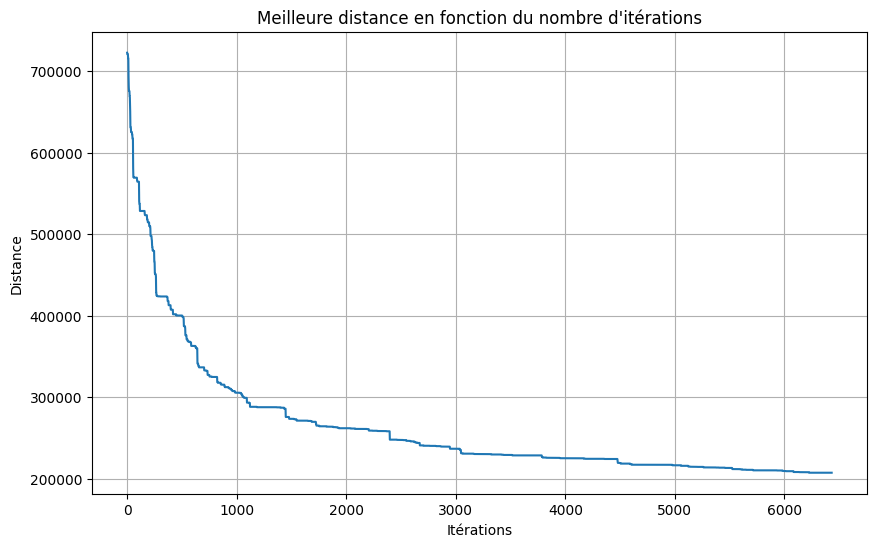

In [35]:
# Tracer la meilleure distance par rapport aux itérations
plt.figure(figsize=(10, 6))
plt.plot(best_distances)
plt.title('Meilleure distance en fonction du nombre d\'itérations')
plt.xlabel('Itérations')
plt.ylabel('Distance')
plt.grid(True)
plt.show()

Par question de simple curiosité, on pourrait estimer le temps que mettrait une voiture afin de parcourir cette distance en faisant bien sur de grosse abstrations sur le fait qu'il faudrait prendre le bateau, et que nous ne nous déplacerions pas quelque soit le mode de transport uniformément à 100 km/h

In [36]:
def estimate_travel_time(distance, speed=100, stop_duration=1, n_stops=10):

    # Temps de déplacement
    travel_time = distance / speed

    # Temps total des arrêts
    total_stop_time = stop_duration * n_stops

    # Temps total
    total_time = travel_time + total_stop_time

    return total_time

# Meilleure distance déjà calculée avec l'algorithme du recuit simulé
best_distance

# Estimation du temps de trajet
time_required = estimate_travel_time(best_distance)
print(f"Le temps estimé pour le trajet est de {time_required:.2f} heures.")

Le temps estimé pour le trajet est de 2082.03 heures.


Interessons-nous maintenant à la performance d'un tel algorithme en termes de temps d'éxécution avec la fonction time()

In [37]:
def evaluate_performance(func, *args, **kwargs):

  # Mesure du temps d'exécution
    start_time = time.time()
    result = func(*args, **kwargs)
    end_time = time.time()

    execution_time = end_time - start_time

    return result, execution_time

# Trouver l'index de Shanghai
shanghai_idx = Noms.index('Shanghai')

# Utilisation de la fonction d'évaluation
result, exec_time = evaluate_performance(simulated_annealing_tsp_v2, coords_list, 10000, 0.995, shanghai_idx)

print(f"Résultat: {result[1]}")  # affiche la distance du meilleur chemin
print(f"Temps d'exécution: {exec_time:.4f} secondes")

Résultat: 205218.77223345172
Temps d'exécution: 7.0281 secondes


## Interprétation des résultats

Nous pouvons tirer diverses remarques et conclusions des résultats que l'on a obtenu:

- Distance: La distance parait très élevée en comparaison aux données de mes coéquipiers et comparé aux données que m'a fournies GoogleMaps en dessous de 100000 km. Il aurait été interessant de calculer la disance totale maximale afin de comparer de manière astucieuse.
- Nombre d'itérations: 6300 itérations qui est un nombre conséquent ne fournit pas de résultat satisfaisant même si l'algorithme converge. Il est possible que le graphique soit trompeur et que l'on puisse encore descendre en distance. Dans ce cas, il faudrait plus d'itérations.
- Performance: Le temps d'éxécution est très court mais cela n'est pas gage de qualité au vue du nombre d'itérations qui sont donc peut être trop rapidement faites. Il est possible qu'il y ait un problème au niveau de la méthode de recombinaison

Finalement, cet algorithme bien que complexe est applicable à un certain niveau de precision sur divers problèmes. Dans le cas du problème du TSP, il n'est pas l'algorithme à privilégier.